# Copy Paste Tester
Generates a board and prompt to paste in to your reasoning model of choice and allows you to paste and judge it's response.

Initial board:


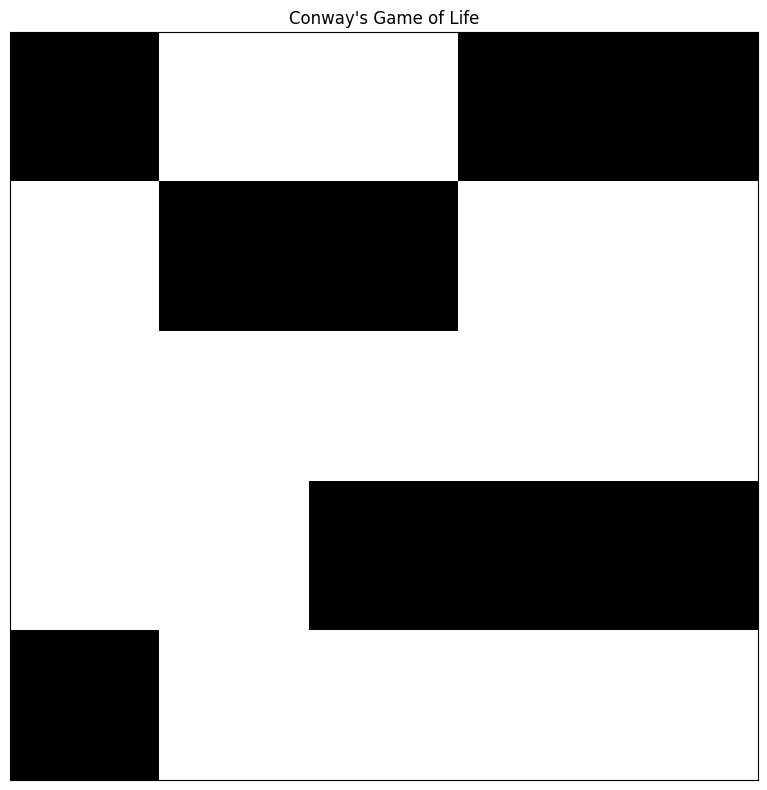


--------------------------------------------------------------------------------
COPY THE FOLLOWING PROMPT TO SEND TO THE LLM:
--------------------------------------------------------------------------------

You are tasked with predicting the next state of Conway's Game of Life.

The rules of Conway's Game of Life are:
1. Any live cell with fewer than two live neighbors dies (underpopulation)
2. Any live cell with two or three live neighbors survives
3. Any live cell with more than three live neighbors dies (overpopulation)
4. Any dead cell with exactly three live neighbors becomes a live cell (reproduction)

Current board state (5x5):
1 0 0 1 1
0 1 1 0 0
0 0 0 0 0
0 0 1 1 1
1 0 0 0 0

For each cell, I want you to:
1. Count how many live neighbors it has
2. Apply the rules to determine if it will be alive (1) or dead (0) in the next state
3. Clearly state your conclusion for that cell

After reasoning through all cells, please output the complete next board state as a grid of 0s and 

**Visual representation of the board:**
```
■□□■■
□■■□□
□□□□□
□□■■■
■□□□□
```

After getting the response, run the next cell to evaluate the result.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pickle
import os
from IPython.display import display, Markdown

# Import the GameOfLife class from game_of_life.py
from game_of_life import GameOfLife

# Parameters for board generation
board_size = 5  # Size of the square board (change as needed)
density = 0.3   # Density of live cells (change as needed)

# Create a Game of Life instance with a random board
game = GameOfLife(size=(board_size, board_size))
game.random_board(density=density)

# Display the initial board
print("Initial board:")
game.display()

# Store the initial board
initial_board = game.get_board()

# Calculate the correct next state using the built-in method
correct_next_state = game.next()

# Reset the board to the initial state
game.set_board(initial_board)

# Convert board to string representation for the prompt
board_str = "\n".join(" ".join(str(cell) for cell in row) for row in initial_board)

# Create detailed prompt with instructions for cell-by-cell reasoning
prompt = f"""You are tasked with predicting the next state of Conway's Game of Life.

The rules of Conway's Game of Life are:
1. Any live cell with fewer than two live neighbors dies (underpopulation)
2. Any live cell with two or three live neighbors survives
3. Any live cell with more than three live neighbors dies (overpopulation)
4. Any dead cell with exactly three live neighbors becomes a live cell (reproduction)

Current board state ({board_size}x{board_size}):
{board_str}

For each cell, I want you to:
1. Count how many live neighbors it has
2. Apply the rules to determine if it will be alive (1) or dead (0) in the next state
3. Clearly state your conclusion for that cell

After reasoning through all cells, please output the complete next board state as a grid of 0s and 1s, with the exact same dimensions ({board_size}x{board_size}).

Format your final answer as follows:
FINAL BOARD:
[board representation with only 0s and 1s, no other characters]
END BOARD

Now, proceed with your cell-by-cell analysis:
"""

# Save the initial state, correct next state, and board size for later use
if not os.path.exists('saved_data'):
    os.makedirs('saved_data')

with open('saved_data/game_data.pkl', 'wb') as f:
    pickle.dump({
        'initial_board': initial_board,
        'correct_next_state': correct_next_state,
        'board_size': board_size
    }, f)

# Display the prompt for the user to copy-paste
print("\n" + "-"*80)
print("COPY THE FOLLOWING PROMPT TO SEND TO THE LLM:")
print("-"*80 + "\n")
print(prompt)
print("\n" + "-"*80)

# Also show a visual representation of the board using Unicode characters
visual_board = "\n".join("".join("■" if cell == 1 else "□" for cell in row) for row in initial_board)
display(Markdown(f"**Visual representation of the board:**\n```\n{visual_board}\n```"))

print("After getting the response, run the next cell to evaluate the result.")

Loaded game data with board size 5x5
Initial board:


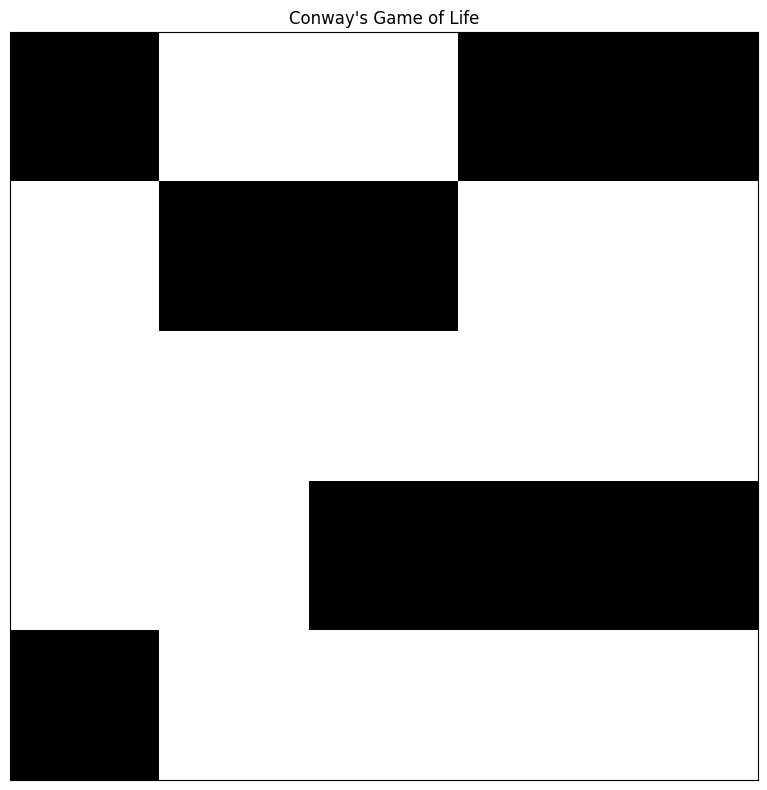

Predicted next state from LLM:


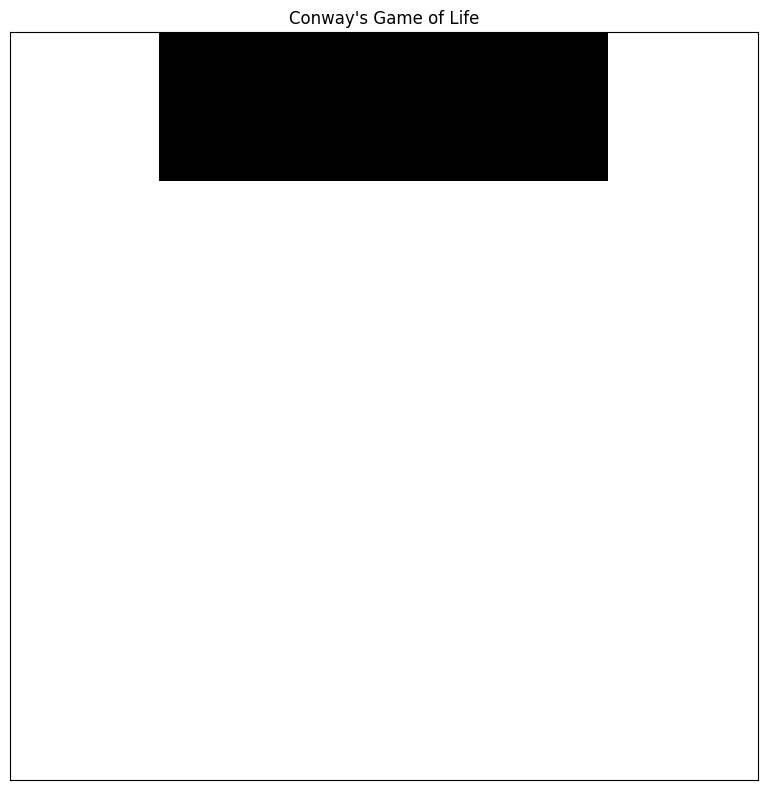

Correct next state (using built-in rules):


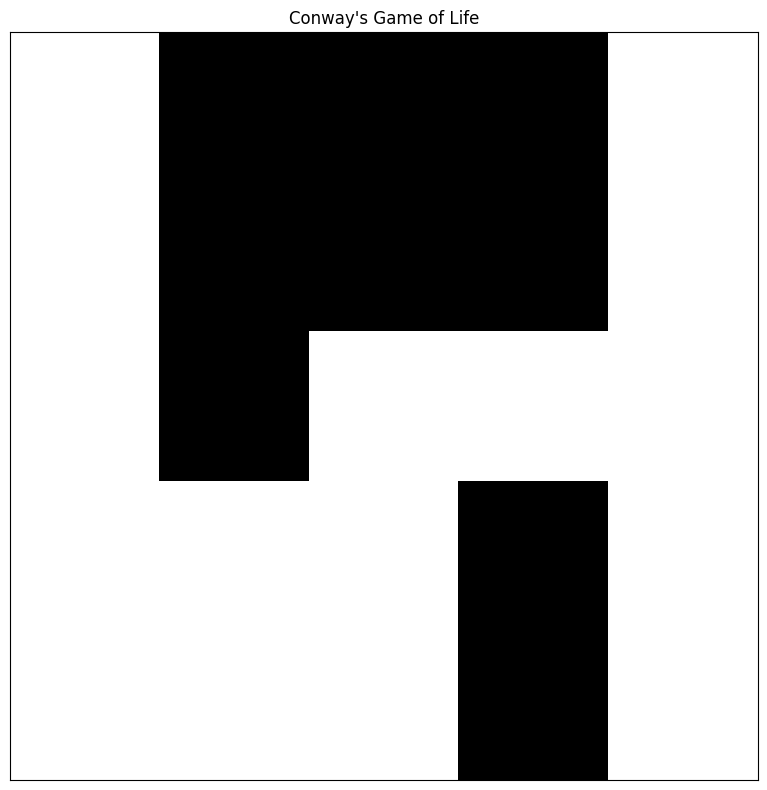

Comparing results...


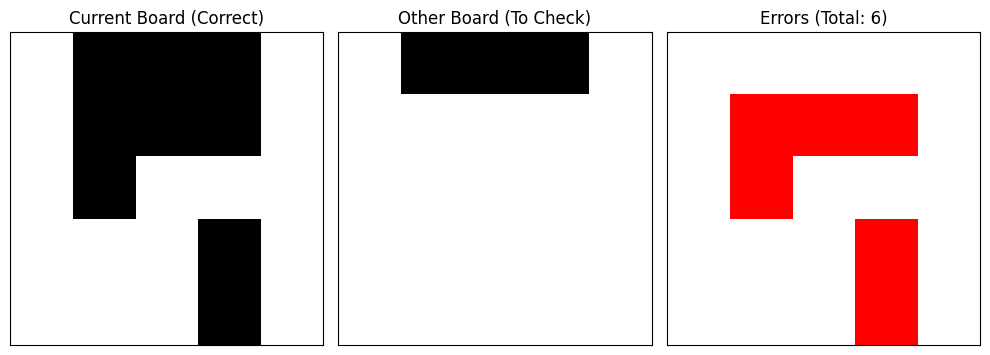

Accuracy: 76.00% (19/25 cells correct)
Results saved for future reference.


In [4]:
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from game_of_life import GameOfLife

def parse_board_from_text(text, expected_rows, expected_cols):
    """
    Parse a board from text format into a 2D numpy array.
    This is robust to various delimiters and whitespace.
    
    Args:
        text: String representation of the board
        expected_rows: Expected number of rows
        expected_cols: Expected number of columns
        
    Returns:
        board: 2D numpy array representing the board
    """
    # Remove any non-relevant characters, keeping only 0s, 1s, and whitespace
    clean_text = re.sub(r'[^01\s]', '', text)
    
    # Split into rows
    rows = [row for row in clean_text.strip().split('\n') if row.strip()]
    
    # Create the board
    board = np.zeros((expected_rows, expected_cols), dtype=int)
    
    # Try to parse the text into the board
    for i, row_text in enumerate(rows):
        if i >= expected_rows:
            break
            
        # Extract just the 0s and 1s
        digits = re.findall(r'[01]', row_text)
        
        for j, digit in enumerate(digits):
            if j >= expected_cols:
                break
            board[i, j] = int(digit)
    
    # Check if the board has the expected dimensions
    if len(rows) != expected_rows or any(len(re.findall(r'[01]', row)) != expected_cols for row in rows[:expected_rows]):
        print(f"Warning: Parsed board dimensions ({len(rows)}x{len(re.findall(r'[01]', rows[0]) if rows else 0)}) "
              f"don't match expected dimensions ({expected_rows}x{expected_cols})")
    
    return board

# Load the saved game data
try:
    with open('saved_data/game_data.pkl', 'rb') as f:
        game_data = pickle.load(f)
    
    initial_board = game_data['initial_board']
    correct_next_state = game_data['correct_next_state']
    board_size = game_data['board_size']
    
    print(f"Loaded game data with board size {board_size}x{board_size}")
except FileNotFoundError:
    print("Error: No saved game data found. Please run the first cell to generate a board and prompt.")
    raise

# Create instances for display
initial_game = GameOfLife(board=initial_board)
correct_game = GameOfLife(board=correct_next_state)

# Show the initial board again
print("Initial board:")
initial_game.display()

# Get the LLM's response
llm_response = input("Paste the FULL response from the LLM here: ")

# Try to extract the final board from the response
predicted_board = None

# First, try to find a board between "FINAL BOARD:" and "END BOARD"
if "FINAL BOARD:" in llm_response and "END BOARD" in llm_response:
    board_section = llm_response.split("FINAL BOARD:")[1].split("END BOARD")[0].strip()
    predicted_board = parse_board_from_text(board_section, board_size, board_size)
else:
    # If we can't find the markers, try to extract a board from the end of the response
    lines = llm_response.strip().split('\n')
    last_part = '\n'.join(lines[-board_size-5:])
    predicted_board = parse_board_from_text(last_part, board_size, board_size)

if predicted_board is None:
    print("Error: Could not parse a valid board from the LLM response.")
else:
    # Create an instance with the predicted board
    predicted_game = GameOfLife(board=predicted_board)
    
    # Display the predicted next state
    print("Predicted next state from LLM:")
    predicted_game.display()
    
    # Display the correct next state
    print("Correct next state (using built-in rules):")
    correct_game.display()
    
    # Compare the results
    print("Comparing results...")
    correct_game.display_errors(predicted_board)
    
    # Calculate accuracy
    total_cells = np.prod(initial_board.shape)
    differences = np.sum(correct_next_state != predicted_board)
    accuracy = (total_cells - differences) / total_cells * 100
    
    print(f"Accuracy: {accuracy:.2f}% ({total_cells - differences}/{total_cells} cells correct)")
    
    # Save the results
    with open('saved_data/llm_results.pkl', 'wb') as f:
        pickle.dump({
            'initial_board': initial_board,
            'correct_next_state': correct_next_state,
            'predicted_board': predicted_board,
            'llm_response': llm_response,
            'accuracy': accuracy
        }, f)
    
    print("Results saved for future reference.")